In [53]:
import os
import numpy as np
import pandas as pd
#前處理
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
#模型
from sklearn.linear_model import SGDClassifier,LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
DATA_ROOT = "./pm/"
print(os.listdir("./pm"))

['2014.csv', '2015.csv', '2016.csv', 'd2017.csv', 'd2018.csv', 'Demo_test.csv', 'pm.csv', 'pm2014.csv', 'pm2015.csv', 'pm2016.csv', 'pm2017.csv', 'pm2018.csv', 'pmall.csv', 'pmmergeclean.csv', 'pmtest.csv', 'pmtest1.csv', 'pm_train.csv', 'test.csv', '空氣品質監測小時值.csv', '空氣品質監測小時值xxx.csv', '離群值.PNG', '離群值2.PNG']


In [3]:
#此處先手動清理PM2.5中有異常文字型態的資料及空缺值
dataclean = pd.read_csv(os.path.join(DATA_ROOT,'pmmergeclean.csv'), encoding='big5')
print(dataclean['PM2.5'].dtype)
daidx,col = dataclean.shape
print(f'資料維度:{daidx,col}')
dataclean.head(3)

int64
資料維度:(2587, 19)


,NOx,WIND_DIREC,O3,NMHC,CO,NO,NO2,RH,PM10,CH4,WIND_SPEED,AMB_TEMP,THC,WS_HR,WD_HR,SO2,DATE,Hour,PM2.5
0,5.4,258.0,9.7,0.01,0.10,0.7,4.7,77.0,16.0,1.7,1.7,29.0,1.7,1.2,253.0,1.5,2018/6/30,0,4
1,4.3,258.0,14.0,0.00,0.09,0.2,4.1,77.0,14.0,1.7,1.4,29.0,1.7,1.3,256.0,1.0,2018/6/30,1,9
2,3.3,265.0,16.0,0.00,0.09,-0.1,3.4,80.0,17.0,1.7,0.8,29.0,1.7,1.2,256.0,0.6,2018/6/30,2,6


In [4]:
import datetime
dataclean['DATE'] = dataclean['DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y/%m/%d'))
dataclean['YEAR'] = dataclean['DATE'].apply(lambda x: datetime.datetime.strftime(x, '%Y')).astype('int64')#or object
dataclean['MONTH'] = dataclean['DATE'].apply(lambda x: datetime.datetime.strftime(x, '%m')).astype('int64')#or object
dataclean['DAY'] = dataclean['DATE'].apply(lambda x: datetime.datetime.strftime(x, '%d')).astype('int64')# use object
#dataclean['WEEK'] = dataclean['DATE'].apply(lambda x:datetime.datetime.strftime(x, '%A')).astype('object')
dataclean['WEEK_NUM'] = dataclean['DATE'].apply(lambda x:datetime.datetime.strftime(x,'%w')).astype('int64')
dataclean = dataclean.drop(['DATE'],axis = 1)
dataclean = dataclean.drop(['YEAR'],axis = 1)
dataclean = dataclean.drop(['MONTH'],axis = 1)
dataclean.head(3)

,NOx,WIND_DIREC,O3,NMHC,CO,NO,NO2,RH,PM10,CH4,WIND_SPEED,AMB_TEMP,THC,WS_HR,WD_HR,SO2,Hour,PM2.5,DAY,WEEK_NUM
0,5.4,258.0,9.7,0.01,0.10,0.7,4.7,77.0,16.0,1.7,1.7,29.0,1.7,1.2,253.0,1.5,0,4,30,6
1,4.3,258.0,14.0,0.00,0.09,0.2,4.1,77.0,14.0,1.7,1.4,29.0,1.7,1.3,256.0,1.0,1,9,30,6
2,3.3,265.0,16.0,0.00,0.09,-0.1,3.4,80.0,17.0,1.7,0.8,29.0,1.7,1.2,256.0,0.6,2,6,30,6


In [5]:
y_train = dataclean['PM2.5']
#dataclean.drop(['PM2.5'],axis =1,inplace = True)

In [6]:
intfloat_feature = []
for dtype,feature in zip(dataclean.dtypes,dataclean.columns):
    if dtype == 'int64' or dtype =='float64':
        intfloat_feature.append(feature)
object_feature = []
for dtype,feature in zip(dataclean.dtypes,dataclean.columns):
    if dtype == 'object':
        object_feature.append(feature)
print(f'Num_feature:{intfloat_feature}')
print(f'Obj_feature:{object_feature}')

Num_feature:['NOx', 'WIND_DIREC', 'O3', 'NMHC', 'CO', 'NO', 'NO2', 'RH', 'PM10', 'CH4', 'WIND_SPEED', 'AMB_TEMP', 'THC', 'WS_HR', 'WD_HR', 'SO2', 'Hour', 'PM2.5', 'DAY', 'WEEK_NUM']
Obj_feature:[]


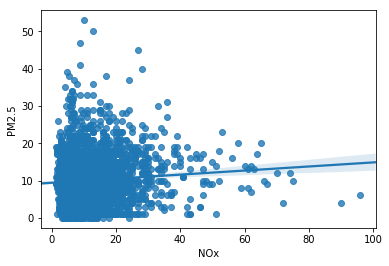

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


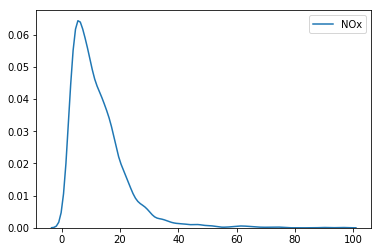

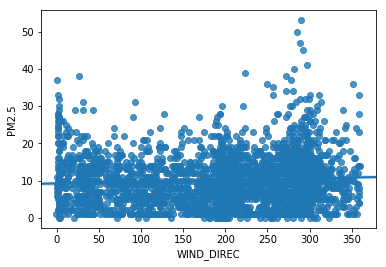

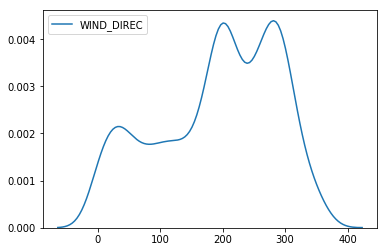

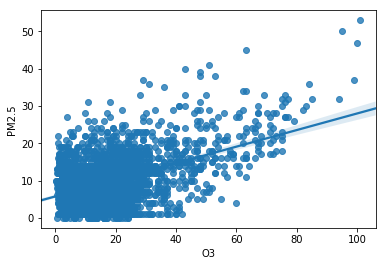

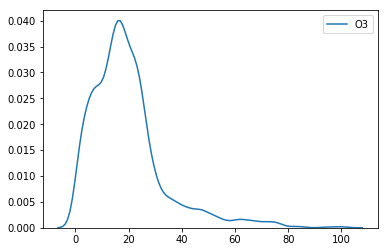

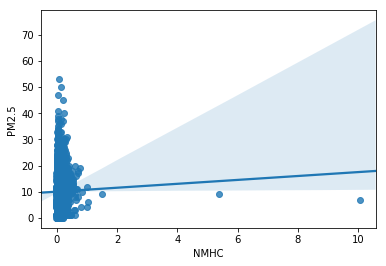

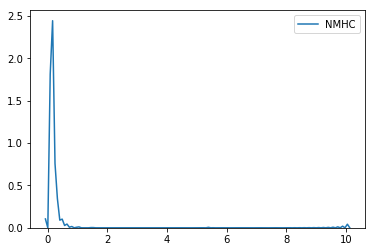

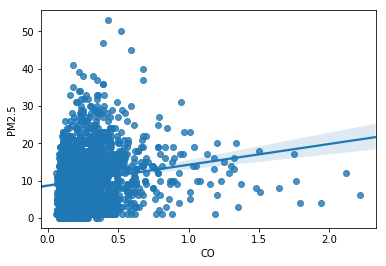

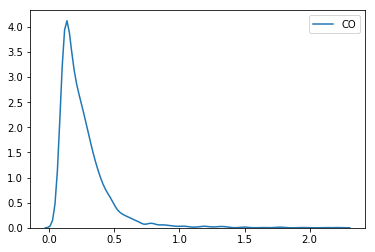

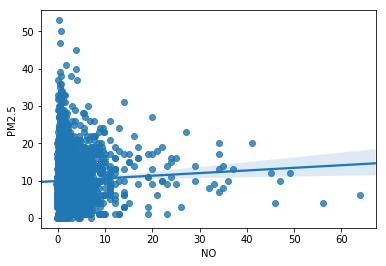

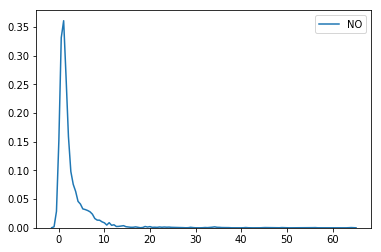

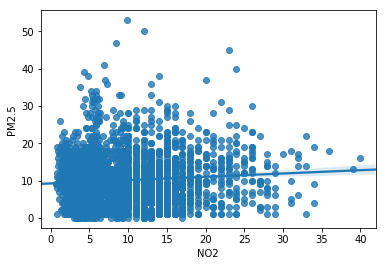

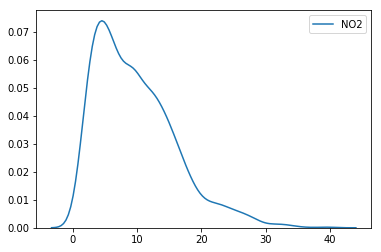

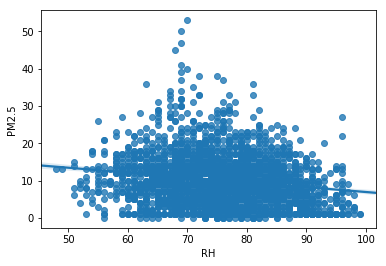

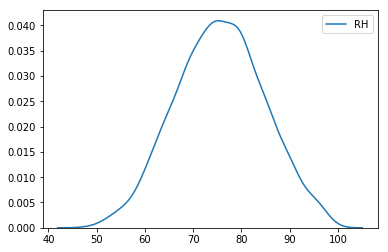

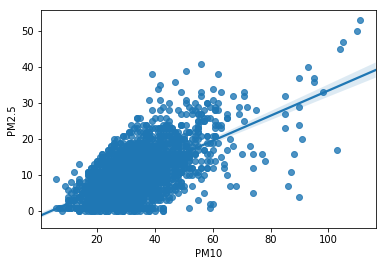

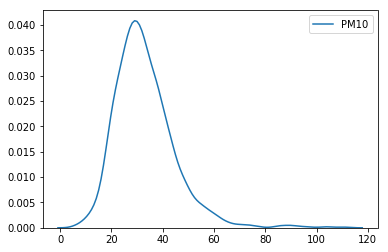

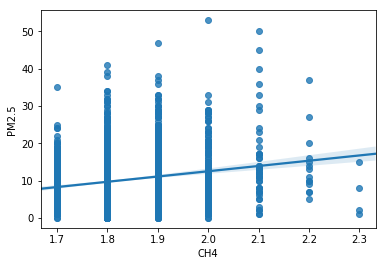

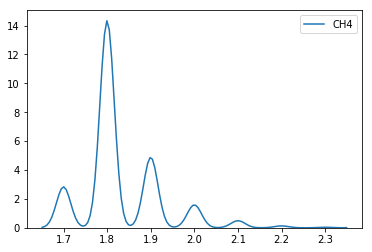

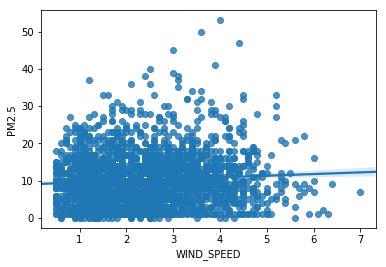

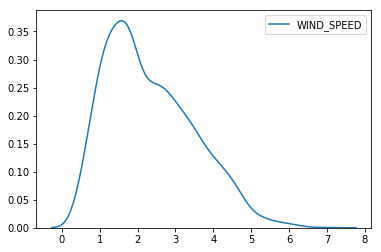

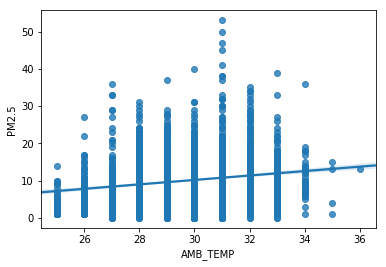

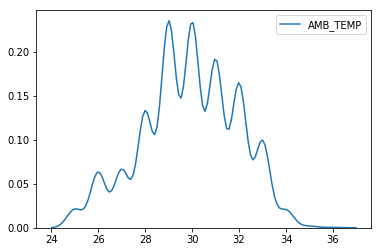

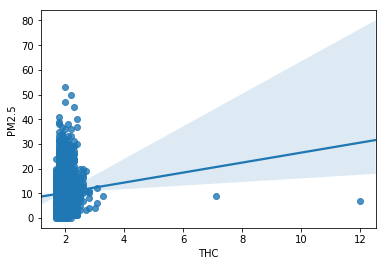

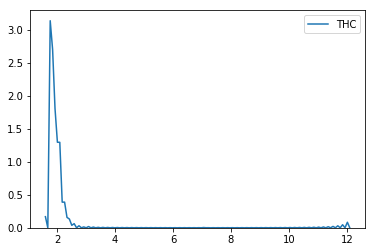

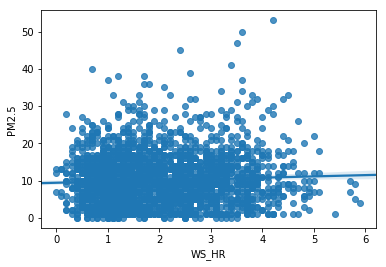

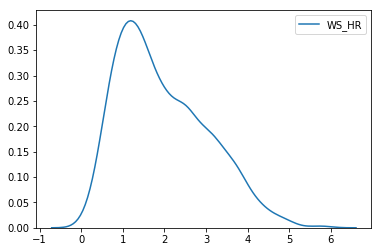

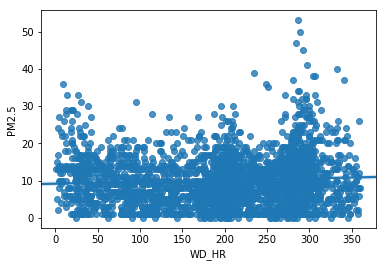

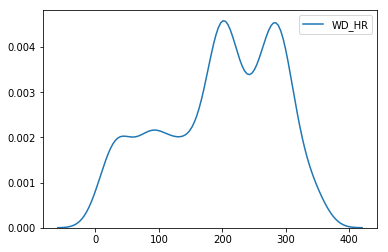

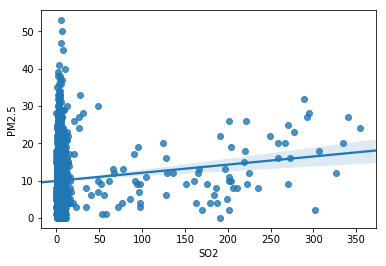

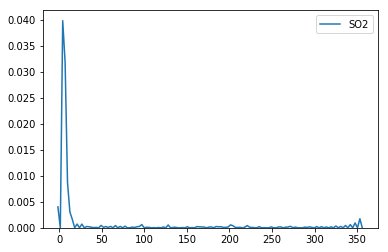

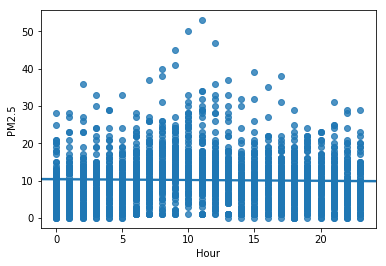

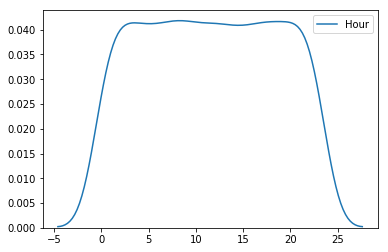

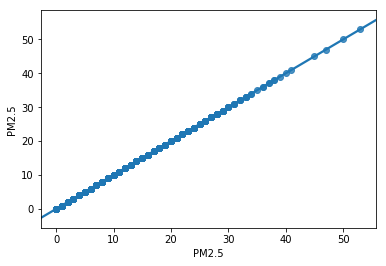

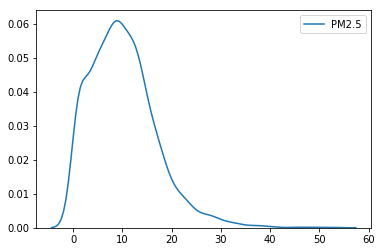

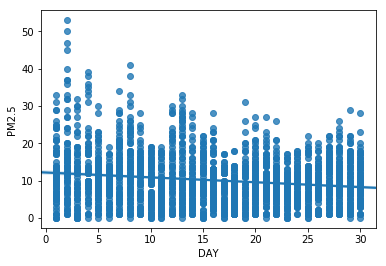

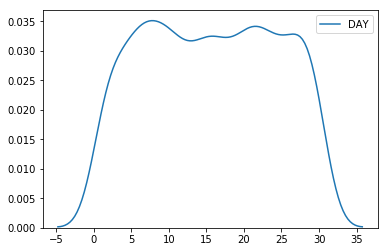

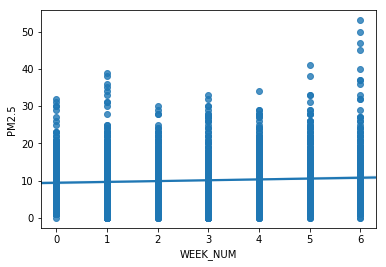

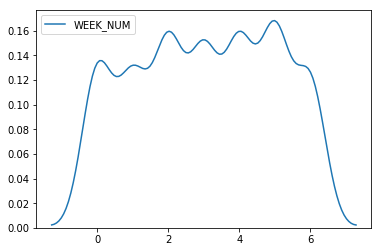

In [7]:

for i in intfloat_feature:
    sns.regplot(x = dataclean[i],y = y_train)
    plt.show()
    sns.kdeplot(dataclean[i])
    plt.show()


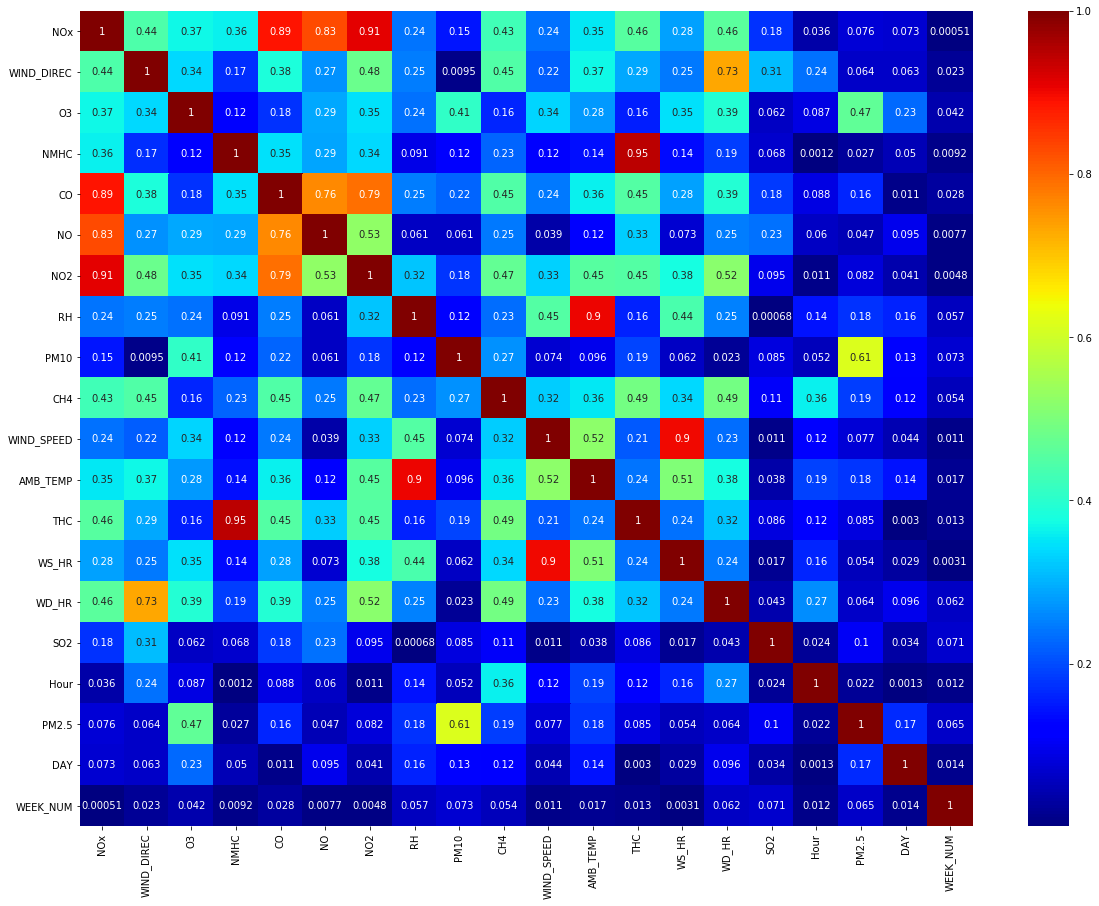

In [8]:
'''自變數相似度'''
corr_mat = dataclean.corr().abs()
plt.subplots(figsize = (20,15))
sns.heatmap(corr_mat,cmap = 'jet',annot = True)

In [9]:
'''消除自變數相關性高的特徵'''
upper = corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column]>0.75)]
print(to_drop)
dataclean.drop(to_drop,axis =1 ,inplace = True)
print(f'dataclean shape:{dataclean.shape}')
dataclean.head(3)

['CO', 'NO', 'NO2', 'AMB_TEMP', 'THC', 'WS_HR']
dataclean shape:(2587, 14)


,NOx,WIND_DIREC,O3,NMHC,RH,PM10,CH4,WIND_SPEED,WD_HR,SO2,Hour,PM2.5,DAY,WEEK_NUM
0,5.4,258.0,9.7,0.01,77.0,16.0,1.7,1.7,253.0,1.5,0,4,30,6
1,4.3,258.0,14.0,0.00,77.0,14.0,1.7,1.4,256.0,1.0,1,9,30,6
2,3.3,265.0,16.0,0.00,80.0,17.0,1.7,0.8,256.0,0.6,2,6,30,6


In [10]:
dataclean.isnull().any().values

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False, False, False, False])

In [12]:
'''遺失值補值'''
for dtype,feature in zip(dataclean.dtypes,dataclean.columns):
    
    if dtype == 'float64' or dtype =='int64':
        #處理負值
        negidx = dataclean.loc[:][feature]<0
        #dataclean.loc[negidx,feature]  = (dataclean[feature].mode()[0]+dataclean[feature].describe()['mean'])/2 #以眾數與平均值的平均取代      
        dataclean.loc[negidx,feature]  = (dataclean[feature].mode()[0])
        #處理空缺值
        dataclean[feature].fillna(dataclean[feature].mode()[0], inplace=True)

In [14]:
dataclean.isnull().any().values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [15]:
PM25 = dataclean['PM2.5']
dataclean.drop(['PM2.5'],axis =1,inplace = True)

In [16]:
intfloat_feature = []
for dtype,feature in zip(dataclean.dtypes,dataclean.columns):
    if dtype == 'int64' or dtype =='float64':
        intfloat_feature.append(feature)
object_feature = []
for dtype,feature in zip(dataclean.dtypes,dataclean.columns):
    if dtype == 'object':
        object_feature.append(feature)
print(f'Num_feature:{intfloat_feature}')
print(f'Obj_feature:{object_feature}')

Num_feature:['NOx', 'WIND_DIREC', 'O3', 'NMHC', 'RH', 'PM10', 'CH4', 'WIND_SPEED', 'WD_HR', 'SO2', 'Hour', 'DAY', 'WEEK_NUM']
Obj_feature:[]


In [17]:
dataclean.head(3)

,NOx,WIND_DIREC,O3,NMHC,RH,PM10,CH4,WIND_SPEED,WD_HR,SO2,Hour,DAY,WEEK_NUM
0,5.4,258.0,9.7,0.01,77.0,16.0,1.7,1.7,253.0,1.5,0,30,6
1,4.3,258.0,14.0,0.00,77.0,14.0,1.7,1.4,256.0,1.0,1,30,6
2,3.3,265.0,16.0,0.00,80.0,17.0,1.7,0.8,256.0,0.6,2,30,6


In [18]:
keep_index = (dataclean['NMHC']<5)
dataclean = dataclean[keep_index]
PM25 = PM25[keep_index]
print(f'dataclean shape:{dataclean.shape}')
print(f'PM2.5 shape:{PM25.shape}')
dataclean.head(3)

dataclean shape:(2585, 13)
PM2.5 shape:(2585,)


,NOx,WIND_DIREC,O3,NMHC,RH,PM10,CH4,WIND_SPEED,WD_HR,SO2,Hour,DAY,WEEK_NUM
0,5.4,258.0,9.7,0.01,77.0,16.0,1.7,1.7,253.0,1.5,0,30,6
1,4.3,258.0,14.0,0.00,77.0,14.0,1.7,1.4,256.0,1.0,1,30,6
2,3.3,265.0,16.0,0.00,80.0,17.0,1.7,0.8,256.0,0.6,2,30,6


In [19]:
'''特徵轉換'''
MMEncoder = MinMaxScaler()
OHEncoder = OneHotEncoder()
SDEncoder =StandardScaler()
for i in intfloat_feature:
    dataclean[i] = SDEncoder.fit_transform(dataclean[i].values.reshape(-1,1))
dataclean.head(3)

,NOx,WIND_DIREC,O3,NMHC,RH,PM10,CH4,WIND_SPEED,WD_HR,SO2,Hour,DAY,WEEK_NUM
0,-0.762097,0.690367,-0.697417,-0.805932,0.155530,-1.438138,-1.468056,-0.544140,0.636477,-0.207760,-1.653237,1.647979,1.51369
1,-0.878343,0.690367,-0.394168,-0.897190,0.155530,-1.606529,-1.468056,-0.803246,0.669410,-0.223309,-1.509533,1.647979,1.51369
2,-0.984021,0.763503,-0.253122,-0.897190,0.483462,-1.353942,-1.468056,-1.321459,0.669410,-0.235748,-1.365829,1.647979,1.51369


In [23]:
'''
for i in intfloat_feature:
    sns.regplot(x = dataclean[i],y = PM25)
    plt.show()
    sns.kdeplot(dataclean[i])
    plt.show()
'''

'\nfor i in intfloat_feature:\n    sns.regplot(x = dataclean[i],y = PM25)\n    plt.show()\n    sns.kdeplot(dataclean[i])\n    plt.show()\n'

In [25]:
train_X = dataclean

In [43]:
from sklearn.linear_model import Lasso
L1_Reg = Lasso(alpha=0.01)
L1_Reg.fit(train_X, PM25)
L1_Reg.coef_

array([ 1.01336104,  0.28806778,  2.1471414 , -0.1940689 , -0.8608197 ,
        2.86514151,  0.57320318, -0.4414319 ,  0.        ,  0.16961848,
       -0.15351352, -0.35121329,  0.18330138])

In [44]:
from itertools import compress
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))
L1_list = list(compress(list(dataclean), list(L1_mask)))
L1_list

['NOx',
 'WIND_DIREC',
 'O3',
 'NMHC',
 'RH',
 'PM10',
 'CH4',
 'WIND_SPEED',
 'SO2',
 'Hour',
 'DAY',
 'WEEK_NUM']

In [45]:
feasle_train_X = dataclean[L1_list]
feasle_train_X.shape

(2585, 12)

In [48]:
train2_X = feasle_train_X[:2000]
test_X = feasle_train_X[2000:]
train2_Y =PM25[:2000]
test_Y = PM25[2000:]
print(f'train2_X shape:{train2_X.shape}')
print(f'test_X shape:{test_X.shape}')
print(f'train2_Y shape:{train2_Y.shape}')
print(f'test_Y shape:{test_Y.shape}')

train2_X shape:(2000, 12)
test_X shape:(585, 12)
train2_Y shape:(2000,)
test_Y shape:(585,)


In [92]:

linear = LinearRegression(normalize=False, fit_intercept=True, copy_X=True)
#gdbt = GradientBoostingRegressor(tol=0.1, subsample=0.37, n_estimators=200, max_features=20, 
                                 #max_depth=6, learning_rate=0.03)
#rf = RandomForestRegressor(n_estimators=300, min_samples_split=9, min_samples_leaf=10, 
                           #max_features='sqrt', max_depth=8, bootstrap=False)

In [79]:
gdbt = GradientBoostingRegressor(random_state=7)
tol = [0.1,0.01,0.001]
subsample = [0.2,0.4,0.6]
n_estimators=[200,300,400]
max_features= [2,4,5]
max_depth = [4,6,7]
learning_rate=[0.01,0.03,0.005]
param_grid_gbdt = dict(tol = tol,subsample=subsample,n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,learning_rate=learning_rate)


In [80]:
grid_search_gdbt = GridSearchCV(gdbt, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
grid_result_gdbt = grid_search_gdbt.fit(train2_X, train2_Y)


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 991 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 1441 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 1991 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2187 out of 2187 | elapsed:  1.3min finished


In [81]:
print("Best Accuracy: %f using %s" % (grid_result_gdbt.best_score_, grid_result_gdbt.best_params_))

Best Accuracy: -27.059878 using {'learning_rate': 0.01, 'max_depth': 4, 'max_features': 4, 'n_estimators': 400, 'subsample': 0.2, 'tol': 0.1}


In [86]:
gdbt_bestparam = GradientBoostingRegressor(learning_rate=grid_result_gdbt.best_params_['learning_rate'],max_depth=grid_result_gdbt.best_params_['max_depth'],
                                          max_features=grid_result_gdbt.best_params_['max_features'],n_estimators=grid_result_gdbt.best_params_['n_estimators'],
                                          subsample=grid_result_gdbt.best_params_['subsample'],tol=grid_result_gdbt.best_params_['tol'],random_state=7)


In [67]:
rf = RandomForestRegressor(random_state=7,bootstrap=False)
n_estimators=[200,300,400]
min_samples_split=[5,10,15]
min_samples_leaf=[5,10,15]
max_features=['sqrt','auto','log2']
max_depth=[6,10,15]
param_grid_rf = dict(n_estimators=n_estimators,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf
                    ,max_features=max_features,max_depth=max_depth)

In [71]:
grid_search_rf = GridSearchCV(rf, param_grid_rf, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
grid_result_rf = grid_search_rf.fit(train2_X, train2_Y)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed:  1.3min finished


In [73]:
print("Best Accuracy: %f using %s" % (grid_result_rf.best_score_, grid_result_rf.best_params_))

Best Accuracy: -28.161421 using {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 200}


In [87]:
rf_bestparam = RandomForestRegressor(n_estimators=grid_result_rf.best_params_['n_estimators'],min_samples_split=grid_result_rf.best_params_['min_samples_split'],min_samples_leaf=grid_result_rf.best_params_['min_samples_leaf'],
                                    max_features=grid_result_rf.best_params_['max_features'],max_depth=grid_result_rf.best_params_['max_depth'],random_state=7,bootstrap=False)

In [91]:
gdbt_bestparam.fit(train2_X,train2_Y)
gdbt_pred = gdbt_bestparam.predict(test_X)
print(f"gdbt Mean squared error: {mean_squared_error(test_Y,gdbt_pred)}")
rf_bestparam.fit(train2_X,train2_Y)
rf_pred = rf_bestparam.predict(test_X)
print(f"rf Mean squared error: {mean_squared_error(test_Y,rf_pred)}")

gdbt Mean squared error: 24.501714312771238
rf Mean squared error: 23.805369940654614


In [93]:
linear.fit(train2_X,train2_Y)
linear_pred = linear.predict(test_X)
print(f"linear Mean squared error: {mean_squared_error(test_Y,linear_pred)}")

linear Mean squared error: 27.050841395017812
